# Random Forest (SMOTE)
1. impute
2. train, valid, test
3. normalize
4. smote
5. random search for random forest
    - 5.1. Random Search: Calibrate Best Forest
    - 5.2. Random Search: Threshold Best Forest
    - 5.3. Random Search: Best Forest Result
6. grid search from the randomized search
    - 6.1. Grid Search: Calibrate Best Forest
    - 6.2. Grid Search: Threshold Best Forest
    - 6.3. Grid Search: Best Forest Result

In [1]:
import import_ipynb
import pandas as pd
from APS_system_package.data_clean import train_data_clean_v2, test_data_clean_v2
from APS_system_package.preprocessing import *
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Decision Trees\APS\APS_system_package\data_clean.ipynb
importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Decision Trees\APS\APS_system_package\preprocessing.ipynb


In [2]:
def plot_confusion_matrix(y_train, y_train_hat, y_test, y_test_hat):
    # training confusion matrix
    cm = confusion_matrix(y_train, y_train_hat)
    plt.figure(figsize = (6, 6))
    sns.heatmap(cm, annot = True, square = True, fmt = 'g', cbar = False)
    plt.title('Train Data Confusion Matrix')
    plt.xlabel('Predict'); plt.ylabel('Actual')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    train_cost = fp*10 + fn*500
    # testing confusion matrixes
    cm = confusion_matrix(y_test, y_test_hat)
    tn, fp, fn, tp = cm.ravel()
    precision_matrix = np.array([[tn/(tn+fn+1), fp/(fp+tp+1)],
                                 [fn/(tn+fn+1), tp/(fp+tp+1)]])
    recall_matrix    = np.array([[tn/(tn+fp+1), fp/(tn+fp+1)],
                                 [fn/(fn+tp+1), tp/(fn+tp+1)]])
    plt.figure(figsize = (15, 5))
    plt.subplot(131); sns.heatmap(cm, annot = True, fmt = 'g', cbar = False); plt.title('Test Data Confusion Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(132); sns.heatmap(precision_matrix, annot = True, cbar = False); plt.title('Precision Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(133); sns.heatmap(recall_matrix, annot = True, cbar = False); plt.title('Recall Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    test_cost = fp*10 + fn*500
    # print costs
    print(f'Train Dataset Cost:\t{train_cost}')
    print(f'Test Dataset Cost:\t{test_cost}')

In [3]:
def plot_precision_recall_costs(model, data, y_true):
    y_prob = model.predict_proba(data)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1)
    Costs = []
    for t in tqdm(thresholds):
        y_hat = y_prob > t
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fp*10 + fn*500
        Costs.append(cost)
    plt.figure(figsize = (15, 5))
    plt.subplot(131); plt.xlim([0, 1.03]); plt.ylim([0, 1.03])
    plt.plot(recall, precision)
    plt.xlabel('recall'); plt.ylabel('precision')
    plt.title('Recall and Precision Plot')
    
    plt.subplot(132); plt.xlim([0, 1.03]); plt.ylim([0, 1.03])
    plt.plot(thresholds, recall, label = 'recall')
    plt.plot(thresholds, precision, label = 'precision')
    plt.xlabel('threshold'); plt.ylabel('recall and precision')
    plt.legend()
    plt.title('Recall and Precision Plot')
    
    plt.subplot(133); plt.plot(thresholds, Costs)
    plt.xlabel('threshold'); plt.ylabel('cost')
    plt.title('Cost Threshold Plot')
    plt.tight_layout()
    # print best cost, and threshold
    loc = np.argmin(Costs)
    print('Best threshold:\t{}'.format(thresholds[loc]))
    print('Minimize cost:\t{}'.format(Costs[loc]))
    return thresholds[loc]

In [57]:
def fast_precision_recall_costs(model, data, y_true):
    y_prob = model.predict_proba(data)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    Costs = []
    for t in tqdm(thresholds[0:int(len(thresholds)/4)]):
        y_hat = y_prob > t
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fp*10 + fn*500
        Costs.append(cost)
    # print best cost, and threshold
    loc = np.argmin(Costs)
    print('Best threshold:\t{}'.format(thresholds[loc]))
    print('Minimize cost:\t{}'.format(Costs[loc]))
    return thresholds[loc]

In [4]:
def evaluate_model(model, data, y_true, best_threshold):
    # 1. confusion matrix
    # 2. cost
    y_prob = model.predict_proba(data)[:, 1]
    y_hat = y_prob > best_threshold
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    precision_matrix = np.array([[tn/(tn+fn), fp/(fp+tp)],
                                 [fn/(tn+fn), tp/(fp+tp)]])
    recall_matrix    = np.array([[tn/(tn+fp), fp/(tn+fp)],
                                 [fn/(fn+tp), tp/(fn+tp)]])
    plt.figure(figsize = (15, 5))
    plt.subplot(131); sns.heatmap(cm, annot = True, fmt = 'g', cbar = False); plt.title('Data Confusion Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(132); sns.heatmap(precision_matrix, annot = True, cbar = False); plt.title('Precision Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(133); sns.heatmap(recall_matrix, annot = True, cbar = False); plt.title('Recall Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    cost = fp*10 + fn*500
    print(f'Cost: {cost}')

### 1. Impute

In [35]:
impute = 'Mean'
normalize = True
df      = train_data_clean_v2('train.csv', impute = impute)
df_test = test_data_clean_v2('test.csv', df, impute = impute)

Impute with mean
Nan: 0
Impute with mean
Nan: 0


### 2. train, valid, test

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
print('Original training dataset: ')
print('Negative cases: {}'.format(len(df[df['class'] == 0])))
print('Positive cases: {}'.format(len(df[df['class'] == 1])))
y = df.pop('class')
df_train, df_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.15, random_state = 41)
print(f'train dataset: {len(y_train)}')
print(f'valid dataset: {len(y_valid)}')

Original training dataset: 
Negative cases: 59000
Positive cases: 1000
train dataset: 51000
valid dataset: 9000


In [38]:
print(f'train positive cases: {len(y_train[y_train == 1])}')
print(f'valid positive cases: {len(y_valid[y_valid == 1])}')

train positive cases: 842
valid positive cases: 158


In [39]:
y_test = df_test.pop('class')

### 3. Normalize

In [40]:
if normalize:
    norm_obj = MaxMinNormalization(df_train)
    df_train = norm_obj.fit(df_train)
    df_valid = norm_obj.fit(df_valid)
    df_test  = norm_obj.fit(df_test)

### 4. Smote

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
smote = SMOTE()
df_train, y_train = smote.fit_sample(df_train, y_train)
df_valid, y_valid = smote.fit_sample(df_valid, y_valid)
print(f'df_train: {len(df_train)}')
print(f'df_valid: {len(df_valid)}')

df_train: 100316
df_valid: 17684


#### each dataset

In [43]:
print(f'df_train:\t{df_train.shape}')
print(f'df_valid:\t{df_valid.shape}')
print(f'df_test:\t{df_test.shape}')

df_train:	(100316, 170)
df_valid:	(17684, 170)
df_test:	(16000, 170)


### 5. Random Search For Random Forest

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [45]:
start = time.time()
# more advanced search
random_grid = {'max_depth': [2, 3, 5, 8, 10],
               'criterion': ['gini', 'entropy'],
               'n_estimators': [15, 20, 30, 40, 50, 60, 70],
               'min_samples_split': [5, 7, 9, 11],
               'min_samples_leaf': [1, 2, 3, 5, 6, 7],
               'max_features': ['auto', 'sqrt', 'log2'],
               'class_weight': ['balanced', 'balanced_subsample', None]}
rf = RandomForestClassifier(random_state = 41)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 30,
                               scoring = 'recall',
                               cv = 3, verbose = 2,
                               n_jobs = -1)
rf_random.fit(df_train, y_train)
#
end = time.time() - start
print('total run time: {:.0f} seconds'.format(end))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


total run time: 171 seconds


In [46]:
best_rf = rf_random.best_estimator_
rf_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'entropy',
 'class_weight': None}

### 5.1. Random Search: Calibrate Best Forest

In [47]:
from sklearn.calibration import CalibratedClassifierCV

In [48]:
calib = CalibratedClassifierCV(best_rf, cv = 3, method = 'sigmoid')
calib.fit(df_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='entropy',
                                                             max_depth=10,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=7,
                              

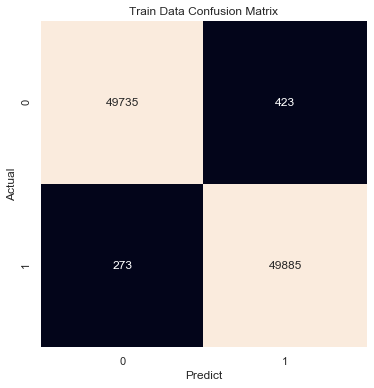

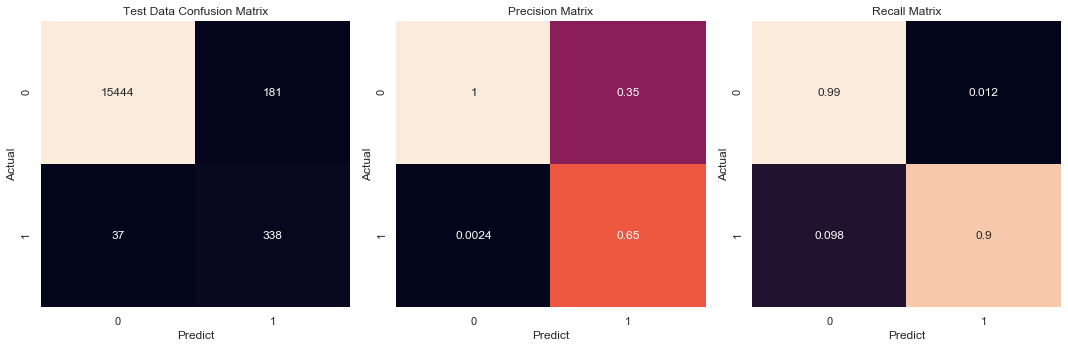

Train Dataset Cost:	140730
Test Dataset Cost:	20310


In [49]:
plot_confusion_matrix(y_train, calib.predict(df_train), y_test, calib.predict(df_test))

### 5.2. Random Search: Threshold Best Forest

100%|██████████| 13954/13954 [07:12<00:00, 32.23it/s]


Best threshold:	0.005436669332795466
Minimize cost:	5890


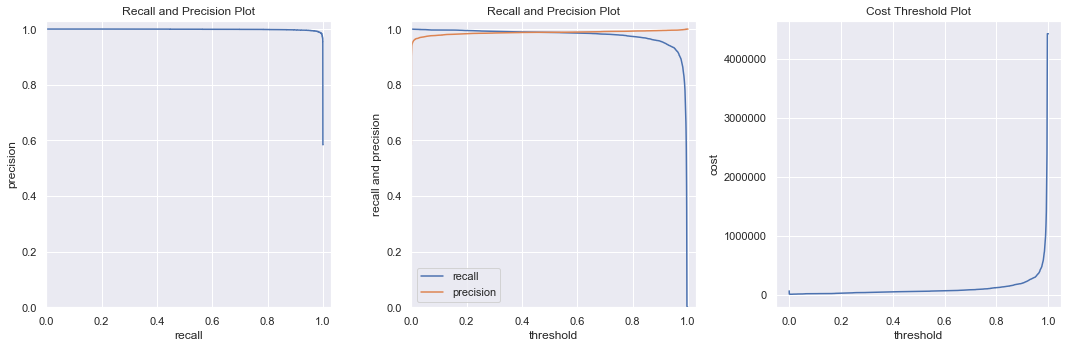

In [50]:
best_threshold = plot_precision_recall_costs(calib, df_valid, y_valid)

### 5.3. Random Search: Best Forest Result

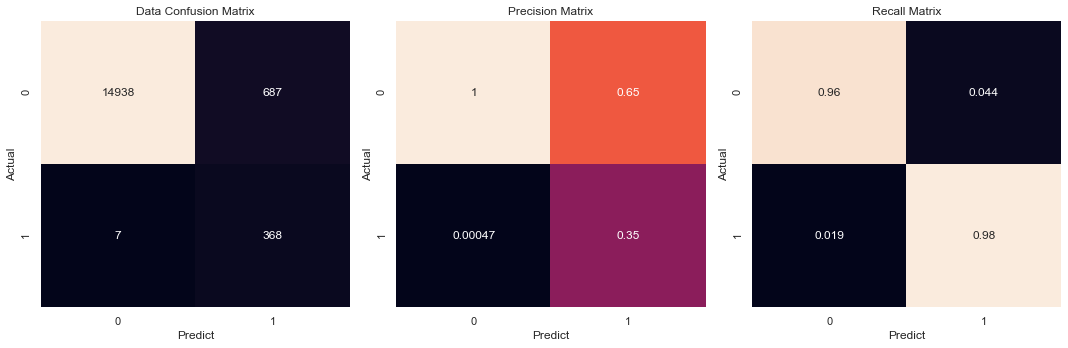

Cost: 10370


In [51]:
evaluate_model(calib, df_test, y_test, best_threshold)

### 6. Grid Search From the Randomized Search

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
rf_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'entropy',
 'class_weight': None}

In [62]:
start = time.time()
# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [60, 70, 80],
              'min_samples_split': [6, 7, 8],
              'min_samples_leaf': [2, 3, 4],
              'max_features': ['auto'],
              'max_depth': [8, 9, 10, 11, 12],
              'criterion': ['entropy'],
              'class_weight': [None]}
rf = RandomForestClassifier(random_state = 41)
rf_grid = GridSearchCV(estimator = rf,
                       param_grid  = param_grid,
                       scoring = 'recall',
                       cv = 3, verbose = 2,
                       n_jobs = -1)
rf_grid.fit(df_train, y_train)
#
end = time.time() - start
print('total run time: {:.0f} seconds'.format(end))

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 33.4min finished


total run time: 2058 seconds


In [70]:
best_grif_rf = rf_grid.best_estimator_
rf_grid.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 80}

### 6.1 Grid Search: Calibrate Best Forest

In [64]:
calib = CalibratedClassifierCV(best_grif_rf, cv = 3, method = 'sigmoid')
calib.fit(df_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='entropy',
                                                             max_depth=12,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=2,
                                                             min_samples_split=6,
                              

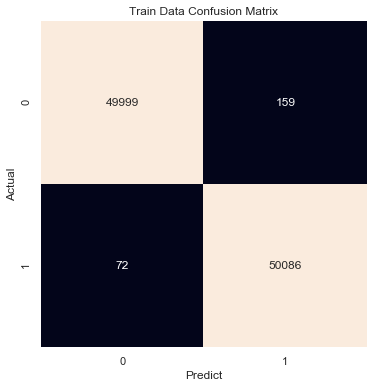

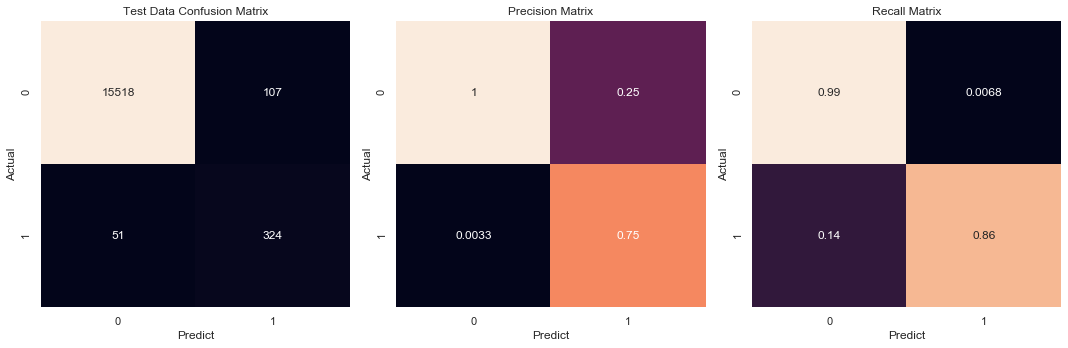

Train Dataset Cost:	37590
Test Dataset Cost:	26570


In [65]:
plot_confusion_matrix(y_train, calib.predict(df_train), y_test, calib.predict(df_test))

### 6.2 Grid Search: Threshold Best Forest

100%|██████████| 13631/13631 [07:13<00:00, 31.46it/s]


Best threshold:	0.0009989000721753148
Minimize cost:	5540


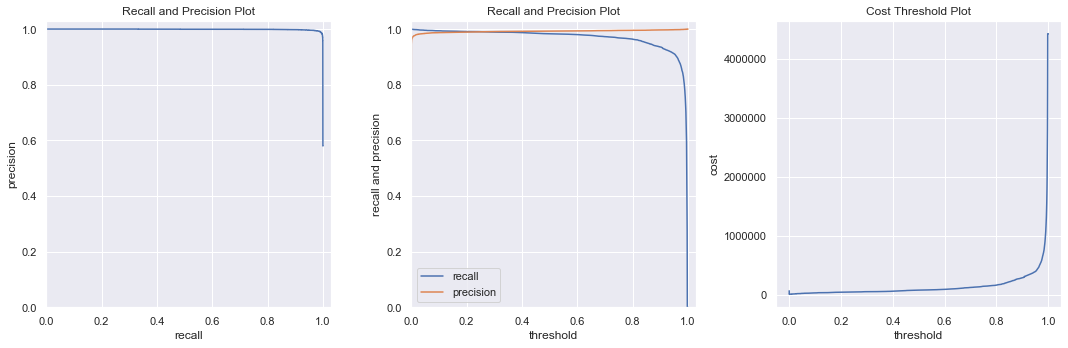

In [66]:
best_threshold = plot_precision_recall_costs(calib, df_valid, y_valid)

### 6.3. Grid Search: Best Forest Result

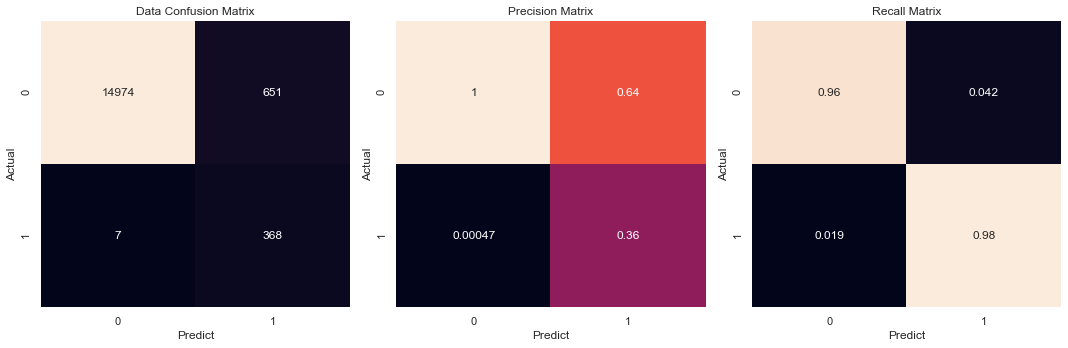

Cost: 10010


In [67]:
evaluate_model(calib, df_test, y_test, best_threshold)

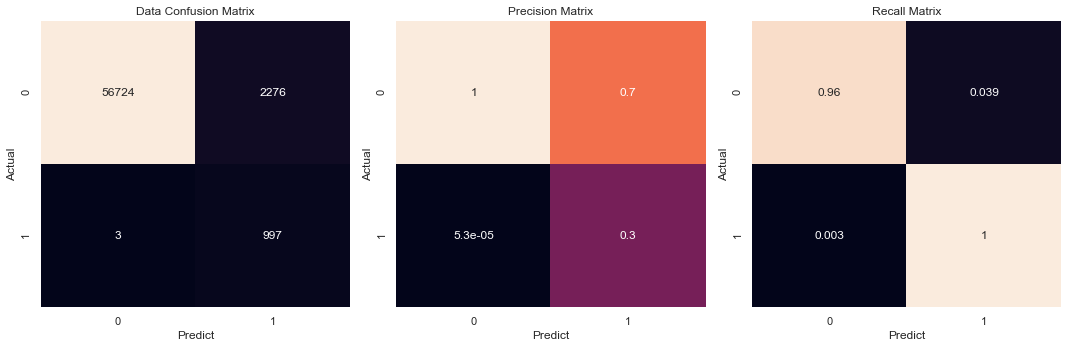

Cost: 24260


In [68]:
df = norm_obj.fit(df)
evaluate_model(calib, df, y, best_threshold)

In [69]:
print(rf_grid.best_params_)
print(f'best threshold = {best_threshold}')

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 80}
best threshold = 0.0009989000721753148
